### This notebook explores the calendar of Munich listings to answer the question: 
## What is the most expensive and the cheapest time to visit Munich?

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
LOCATION = 'munich'

df_list = pd.read_csv(LOCATION + '/listings.csv.gz')
df_reviews = pd.read_csv(LOCATION + '/reviews.csv.gz')
df_cal = pd.read_csv(LOCATION + '/calendar.csv.gz')

In [3]:
pd.options.display.max_rows=10
pd.options.display.max_columns=None
pd.options.display.max_colwidth=30

___

### Calendar

#### First look into to data and types for each column:

In [4]:
df_cal

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,710604,2021-03-23,t,$39.00,$39.00,1.0,1125.0
1,710604,2021-03-24,t,$39.00,$39.00,1.0,1125.0
2,710604,2021-03-25,t,$39.00,$39.00,1.0,1125.0
3,710604,2021-03-26,t,$39.00,$39.00,1.0,1125.0
4,710604,2021-03-27,t,$39.00,$39.00,1.0,1125.0
...,...,...,...,...,...,...,...
1849111,48673500,2022-03-18,f,$40.00,$40.00,25.0,1125.0
1849112,48673500,2022-03-19,f,$40.00,$40.00,25.0,1125.0
1849113,48673500,2022-03-20,f,$40.00,$40.00,25.0,1125.0
1849114,48673500,2022-03-21,f,$40.00,$40.00,25.0,1125.0


In [5]:
df_cal.dtypes

listing_id          int64
date               object
available          object
price              object
adjusted_price     object
minimum_nights    float64
maximum_nights    float64
dtype: object

___

#### Some data types are wrong. In order to be able to work with the data, we need to change some datatypes.

First convert **date** to *datetime* type:

In [6]:
df_cal['date'] = pd.to_datetime(df_cal['date'])

**Price** needs to converted to *float* in order to be able to work with it.

In [7]:
df_cal['price']=df_cal['price'].replace(to_replace='[\$,]', value='', regex=True).astype(float)
df_cal['adjusted_price']=df_cal['adjusted_price'].replace(to_replace='[\$,]', value='', regex=True).astype(float)

This is how it looks now:

In [8]:
df_cal.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,710604,2021-03-23,t,39.0,39.0,1.0,1125.0
1,710604,2021-03-24,t,39.0,39.0,1.0,1125.0
2,710604,2021-03-25,t,39.0,39.0,1.0,1125.0
3,710604,2021-03-26,t,39.0,39.0,1.0,1125.0
4,710604,2021-03-27,t,39.0,39.0,1.0,1125.0


And this are the corrected data types:

In [9]:
df_cal.dtypes

listing_id                 int64
date              datetime64[ns]
available                 object
price                    float64
adjusted_price           float64
minimum_nights           float64
maximum_nights           float64
dtype: object

___

### First question to be answered is, what is the price distribution over the year:

Let's calculate the mean price over all listings for each day of the year:

First check if we have *NULL* values in the data frame.

In [10]:
df_cal.isnull().sum()

listing_id          0
date                0
available           0
price             340
adjusted_price    340
minimum_nights     26
maximum_nights     26
dtype: int64

*NULL* values have impact to the average (even if very small due to the small number of missing values), let's drop all rows with *NULL* **price**.

In [11]:
df_cal.dropna(subset=['price'], inplace=True)

Now let's group all listings by **date** and calculate the average **price** of all listings for each day:

In [12]:
mean_price = df_cal[['date', 'price']].groupby(by='date').mean().reset_index()

In [13]:
mean_price

,date,price
0,2021-03-22,87.617737
1,2021-03-23,121.844113
2,2021-03-24,121.669695
3,2021-03-25,121.947311
4,2021-03-26,125.078125
...,...,...
372,2022-03-29,117.050151
373,2022-03-30,118.258106
374,2022-03-31,120.142157
375,2022-04-01,80.798122


And plot the result:

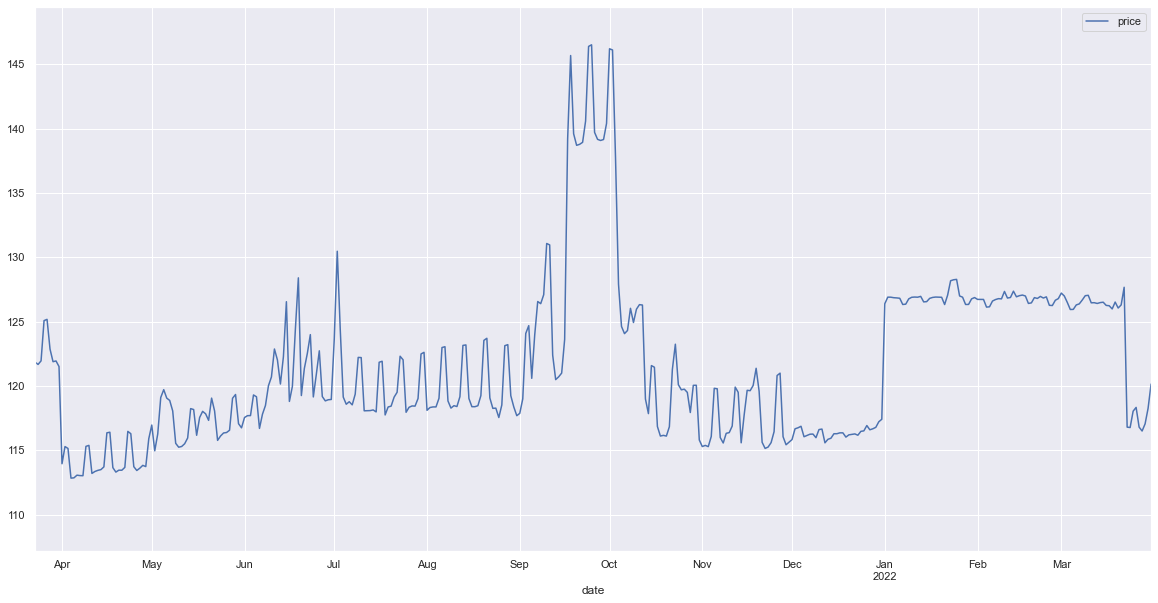

In [14]:
## use the plot method and scale the size based on ploted values
scale_from = mean_price['price'][1:-2].min()*0.95
scale_to = mean_price['price'][1:-2].max()*1.02

mean_price.set_index('date')[1:-2].plot(kind='line', y='price', figsize=(20,10), grid=True).set_ylim(scale_from, scale_to);

###  HERE WE ARE! There are two interesting observations:
#### 1. There is a peak in the second half of September: **"Welcome to the Octoberfest!**"
#### 2. The price apparently depends on the day of week. Let's have a closer look at it.

___

### Second question: What is the price distribution within a week?

To be able to have a close look at prices, let's introduce the **day_of_week** column.

In [15]:
df_cal['day_of_week'] = df_cal['date'].dt.dayofweek

Let's group the prices for each day of week and get the average price:

In [16]:
mean_price_dow = df_cal[['day_of_week', 'price']].groupby(by='day_of_week').mean().reset_index()

In [17]:
mean_price_dow

,day_of_week,price
0,0,120.688993
1,1,121.052007
2,2,120.667118
3,3,120.849175
4,4,123.175604
5,5,123.493037
6,6,120.839011


It's difficult to interpret index-based day of week. Let's convert it to strings from Monday to Sunday:

In [18]:
def convert_day_of_week(day_idx):
    '''
    This function convert index based day of week to string
    0 - Monday
    6 - Sunday
    
    if the day_idx oís out of this range, this index will be returned
    '''    
    
    if(day_idx>6 or day_idx<0):
        return day_idx
    
    lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    return lst[day_idx]

In [19]:
mean_price_dow['day_of_week'] = mean_price_dow['day_of_week'].apply(convert_day_of_week)

In [20]:
mean_price_dow

,day_of_week,price
0,Monday,120.688993
1,Tuesday,121.052007
2,Wednesday,120.667118
3,Thursday,120.849175
4,Friday,123.175604
5,Saturday,123.493037
6,Sunday,120.839011


#### Now we can plot the result:

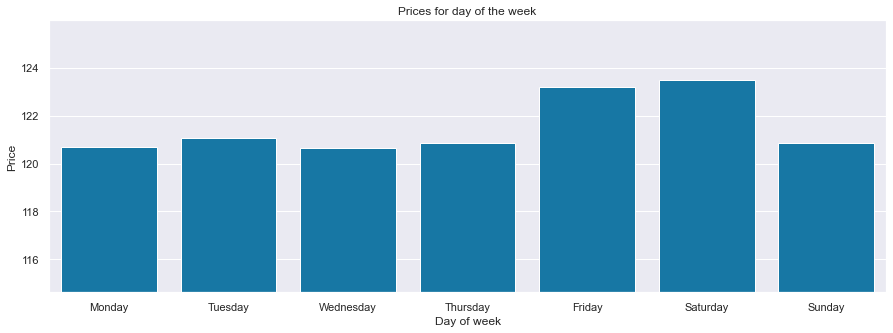

In [21]:
scale_from = mean_price_dow['price'].min()*0.95
scale_to = mean_price_dow['price'].max()*1.02

sns.set(rc={'figure.figsize':(15,5)})
fig = sns.barplot(data=mean_price_dow, x='day_of_week', y='price', color='#0080bb');
fig.set_ylim(scale_from, scale_to);
fig.set_title('Prices for day of the week');
fig.set_xlabel('Day of week');
fig.set_ylabel('Price');

#### No surprise, the most expensive days are Friday and Saturday. The weekend in Munich can start!

___

## What is the most expensive and the cheapest time to visit Munich?

#### If you want to save your money, don't visit Munich during the Octoberfest, which is end of September, beginning of October. Do it better in April, it's much cheaper and you can enjoy green Munich. 

#### If you plan a short trip and you are not constrained by day of week, in order to save the money, Sunday to Thursday is the best choice for you.